PSEUDOCODICE WRITTEN BEFORE IMPLEMENTING MY SOLUTION IN POSTGRES CODE. ACTUALLY, SOME CHANGES AND SOME FIXES ARE DONE IN THE POSTGRES CODE WITHOUT UPDATING THIS FILE. THEREFORE, IT IS LIKELY THAT THIS ALGORITHM IS NOT ACCURATE OR COMPLETELY RIGHT.

In [93]:
import matplotlib.pyplot as plt

NBINS = 6

In [94]:
range_list1 = [(4, 10), (5, 8), (3,5), (20, 33), (15, 17), (15, 18)]
range_list2 = [(7, 11), (12, 14), (15, 20)]

#TODO check if it is correct
def compute_overlaps(range_list1, range_list2):
    overlaps_counter = 0
    for lb1, up1 in range_list1:
        for lb2, up2 in range_list2:
            if lb1 > up2 or up1 < lb2:
                continue
            overlaps_counter += 1 
    return overlaps_counter

compute_overlaps(range_list1, range_list2)

5

In [95]:
def get_variables_for(range_list):
    lower_bounds = [r[0] for r in range_list]
    upper_bounds = [r[1] for r in range_list]

    start_hg = min(lower_bounds)
    end_hg = max(upper_bounds)
    bin_width = (end_hg - start_hg) / NBINS
    print(bin_width)

    bin_starts = [start_hg + bin_width*nbin for nbin in range(NBINS)]

    return lower_bounds, upper_bounds, bin_width, bin_starts

lower_bounds1, upper_bounds1, bin_width1, bin_starts1 = get_variables_for(range_list1)
lower_bounds2, upper_bounds2, bin_width2, bin_starts2 = get_variables_for(range_list2)

5.0
2.1666666666666665


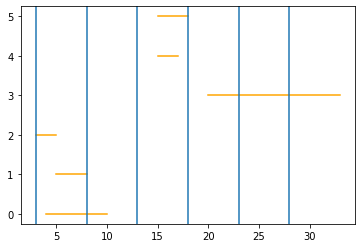

In [96]:
def plot_ranges_and_bins(lower_bounds, upper_bounds, bin_starts, color):
    for lower, upper, y in zip(lower_bounds, upper_bounds, range(len(upper_bounds))):
        plt.plot((lower, upper), (y, y), color=color)

    for bin_start in bin_starts:
        plt.axvline(x=bin_start)

plot_ranges_and_bins(lower_bounds1, upper_bounds1, bin_starts1, 'orange')

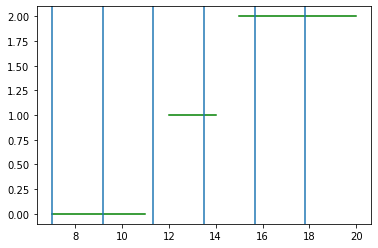

In [97]:
plot_ranges_and_bins(lower_bounds2, upper_bounds2, bin_starts2, 'green')

In [98]:
def compute_frequency(bin_start, lower_bounds, upper_bounds, bin_width):
    bin_end = bin_start + bin_width
    frequency = 0
    for lower, upper in zip(lower_bounds, upper_bounds):
        if lower >= bin_end or upper <= bin_start:
            continue
        frequency += 1
    return frequency

histogram1 = [compute_frequency(bin_start, lower_bounds1, upper_bounds1, bin_width1) for bin_start in bin_starts1]
histogram2 = [compute_frequency(bin_start, lower_bounds2, upper_bounds2, bin_width2) for bin_start in bin_starts2]

#TODO need to move also hg_start and bin_width
start1 = bin_starts1[0]
start2 = bin_starts2[0]
bin_width1
bin_width2

print(histogram1)
print(histogram2)

[3, 1, 2, 1, 1, 1]
[1, 1, 1, 2, 1, 1]


In [99]:
#ESTIMATE SELECTIVITY FOR STRICTLY LEFT
histogram = histogram1
hg_start = start1
bin_width = bin_width1

constant = (50,60)

#find index of closer bin
index=0
cont = 0
while hg_start + bin_width*index < constant[0] and index<NBINS:
    cont += histogram[index]
    index += 1

total_number = sum(histogram)
avg_frequency = total_number / NBINS

'''wrong formula below'''
cont /= avg_frequency # normalizing result (#TODO ADD INTERPOLATION?)
selec = cont/total_number


print(cont)
print(total_number)
print(avg_frequency)
print(selec)

#TODO for strictly right, analogous pseudocode
#TODO for overlap, just use selectivity of these two operators

6.0
9
1.5
0.6666666666666666


In [100]:
# attempts to see if the algorithm always works smoothly
NBINS=6
#histogram1 = [2,3,0,7,4,1]
histogram1 = [3,1,2,1,1,1]
start1 = 7
bin_width1 = 5
# end = 5 + 10*60 = 65

#histogram2 = [0,2,7,1,1,2]
histogram2 = [1,1,1,2,1,1]
start2 = 5
bin_width2 = 5

#TODO HOW TO COMPARE THE TWO HISTOGRAMS FOR JOIN CARDINALITY ESTIMATION???
cont = 0
i1 = 0
i2 = 0

total_number1 = sum(histogram1)
avg_frequency1 = total_number1 / NBINS
total_number2 = sum(histogram2)
avg_frequency2 = total_number2 / NBINS

while(i1<NBINS and i2<NBINS):
    #print(f"i1: {i1}\ti2: {i2}")
    # second histogram
    end2 = start2 + bin_width2
    if end2 <= start1:
        start2 = end2
        i2 += 1
        continue

    # first histogram
    end1 = start1 + bin_width1
    if end1 <= start2:
        start1 = end1
        i1 += 1
        continue

    #print(f"start1: {start1}\tend1: {end1}\tstart2: {start2}\tend2: {end2}\tcont={cont}->", end="")

    cont += histogram1[i1] * histogram2[i2]

    if end1 < end2:
        # increment in the first histogram
        start1 = end1
        i1 += 1
    elif end1 == end2:
        # increment in both the histograms
        start1 = end1
        i1 += 1
        start2 = end2
        i2 += 1
    else:
        # increment in the second histogram
        start2 = end2
        i2 += 1

print(cont)
'''wrong formula below'''
cont /= avg_frequency1/avg_frequency2 # normalizing result (#TODO ADD INTERPOLATION?)
# The number of rows that the join is likely to emit is calculated as the cardinality
# of the Cartesian product of the two inputs multiplied by the selectivity 
selec = cont/(total_number1*total_number2) #TODO check if this formula is correct
print(cont)
print(selec)

20
13.333333333333334
1.4814814814814816
